In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.3f}'.format
from collections import Counter
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import warnings
warnings.filterwarnings("ignore")


# Reviews Dataset

In [ ]:
steam = pd.read_csv('steam_reviews.csv')

In [ ]:
# drop duplicate reviews
steam = steam.drop_duplicates(subset='review_id', keep='first')

### Keep English Reviews only
Focusing on English reviews for more simple NLP process & to reduce the large dataset

In [ ]:
steam = steam[steam['language']=='english']

# since the df contains english reviews only -> can drop language
steam.drop('language', axis=1, inplace=True)
steam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9580668 entries, 3 to 21747369
Data columns (total 22 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   app_id                          int64  
 2   app_name                        object 
 3   review_id                       int64  
 4   review                          object 
 5   timestamp_created               int64  
 6   timestamp_updated               int64  
 7   recommended                     bool   
 8   votes_helpful                   int64  
 9   votes_funny                     int64  
 10  weighted_vote_score             float64
 11  comment_count                   int64  
 12  steam_purchase                  bool   
 13  received_for_free               bool   
 14  written_during_early_access     bool   
 15  author.steamid                  int64  
 16  author.num_games_owned          int64  
 17  author.num_reviews             

In [ ]:
steam.isnull().sum()

Unnamed: 0                            0
app_id                                0
app_name                              0
review_id                             0
review                            16682
timestamp_created                     0
timestamp_updated                     0
recommended                           0
votes_helpful                         0
votes_funny                           0
weighted_vote_score                   0
comment_count                         0
steam_purchase                        0
received_for_free                     0
written_during_early_access           0
author.steamid                        0
author.num_games_owned                0
author.num_reviews                    0
author.playtime_forever               2
author.playtime_last_two_weeks        2
author.playtime_at_review         11836
author.last_played                    2
dtype: int64

## Dropping Unnecessary Columns

### Handling the Different Playtime Columns
Dataset has playtime_forever, playtime_at_review, playtime_last_two_weeks, author.last_played
<li>playtime_forever would be biased for older reviews which have more time to accumulate the hours after review is made</li>
<li>playtime_last_two_weeks would also be biased as the user might review the game and liked it 5 years ago and stopped playing -> lower playtime in last two weeks</li>
<li>these 2 columns would result in lower hours for older reviews</li>
<li>author.last_played is the author time last played reviewed app which is not helpful in our case</li>

We shall keep playtime at review as the reviews capture the user preference at the time of review.

In [ ]:
# we shall keep playtime at review as the user preference is indicated at the time of review
steam.drop(['author.playtime_forever', 'author.playtime_last_two_weeks','author.last_played'], axis=1, inplace=True)

### Votes & Comments Count
<li>votes helpful is the # of votes where other users found the review funny</li>
<li>this information is not useful for our recsys to determine whether a review is more informative/helpful</li>
<li>we will keep votes_helpful and weighted_vote_score which is based on votes_helpfuL</li>
<li>comment count is the # of comments this review received. as we do not have any info to the kind of comments -> not helpful</li>

In [ ]:
steam.drop(['votes_funny','comment_count'], axis=1, inplace=True)

### Timestamp Updated / Created


In [ ]:
print('Count of reviews where timestamp_created != timestamp_updated: ', steam[steam['timestamp_created'] != steam['timestamp_updated']]['review_id'].count())
print('Count of reviews where timestamp created = timestamp_updated: ', steam[steam['timestamp_created'] == steam['timestamp_updated']]['review_id'].count())
print('Count of reviews where timestamp_created > timestamp_updated: ', steam[steam['timestamp_created'] > steam['timestamp_updated']]['review_id'].count())

Count of reviews where timestamp_created != timestamp_updated:  1139434
Count of reviews where timestamp created = timestamp_updated:  8441234
Count of reviews where timestamp_created > timestamp_updated:  0


In [ ]:
# from the above count, timestamp updated will be the same as timestamp created if there are no updates
# if there are updates, it will be reflected in timestamp updated
# therefore we can drop timestamp_created
steam.drop('timestamp_created', axis=1, inplace=True)

### Remaining Columns to Drop
<li>as our model is based on user preferences learnt from their interactions + feedback, we won't incorporate any information if the user received for free / purchased from another gaming distrbution platform</li>
<li>we will drop received_for_free and steam_purchase</li>
<li>author.num_reviews and author.num_games_owned will be replaced by user review counts in the dataset</li>
<li>written_during_early_access dropped as well</li>


In [ ]:
steam.drop(['received_for_free','steam_purchase','author.num_games_owned','author.num_reviews','Unnamed: 0','written_during_early_access'], axis=1, inplace=True)

### Handle Null Values


In [ ]:
steam.isnull().sum()

app_id                           0
app_name                         0
review_id                        0
review                       16682
timestamp_updated                0
recommended                      0
votes_helpful                    0
weighted_vote_score              0
author.steamid                   0
author.playtime_at_review    11836
dtype: int64

#### Null playtime_at_review

In [ ]:
# calculate mean for each game
mean_playtime_per_app = steam.groupby('app_id')['author.playtime_at_review'].transform('mean')

# mean impute for null
steam['author.playtime_at_review'] = steam['author.playtime_at_review'].fillna(mean_playtime_per_app)

#### Null review
we will just drop as there is no way to impute it + we have alot of reviews

In [ ]:
# drop rows with null reviews
steam = steam.dropna(subset=['review'])


In [ ]:
steam.isnull().sum()

app_id                       0
app_name                     0
review_id                    0
review                       0
timestamp_updated            0
recommended                  0
votes_helpful                0
weighted_vote_score          0
author.steamid               0
author.playtime_at_review    0
dtype: int64

### Write to csv

In [ ]:
steam.reset_index(drop=True, inplace=True)

In [ ]:
steam.to_csv('filtered_reviews.csv')

# Game Dataset

In [ ]:
steam_games = pd.read_csv('93182_steam_games.csv')

### Keep Games that are in Reviews Dataset

In [ ]:
filtered_games = steam_games[steam_games['AppID'].isin(steam['app_id'])]
filtered_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 19 to 93122
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       299 non-null    int64  
 1   Name                        299 non-null    object 
 2   Release date                299 non-null    object 
 3   Estimated owners            60 non-null     object 
 4   Peak CCU                    299 non-null    int64  
 5   Required age                299 non-null    int64  
 6   Price                       299 non-null    float64
 7   DLC count                   299 non-null    int64  
 8   About the game              299 non-null    object 
 9   Supported languages         299 non-null    object 
 10  Full audio languages        299 non-null    object 
 11  Reviews                     141 non-null    object 
 12  Header image                299 non-null    object 
 13  Website                     258 non-n

In [ ]:
cols_to_explore = ['AppID', 'Release date', 'Required age', 'Price', 'DLC count', 'About the game', 'Windows', 'Mac', 'Linux', 'Genres', 'Categories', 'Developers', 'Publishers', 'Tags']

filtered_games = filtered_games[cols_to_explore]

In [ ]:
filtered_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299 entries, 19 to 93122
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AppID           299 non-null    int64  
 1   Release date    299 non-null    object 
 2   Required age    299 non-null    int64  
 3   Price           299 non-null    float64
 4   DLC count       299 non-null    int64  
 5   About the game  299 non-null    object 
 6   Windows         299 non-null    bool   
 7   Mac             299 non-null    bool   
 8   Linux           299 non-null    bool   
 9   Genres          299 non-null    object 
 10  Categories      299 non-null    object 
 11  Developers      298 non-null    object 
 12  Publishers      298 non-null    object 
 13  Tags            60 non-null     object 
dtypes: bool(3), float64(1), int64(3), object(7)
memory usage: 28.9+ KB


In [ ]:
filtered_games.head()

,AppID,Release date,Required age,Price,DLC count,About the game,Windows,Mac,Linux,Genres,Categories,Developers,Publishers,Tags
19,382310,"Feb 6, 2018",0,29.990,0,"Enter the world of Eco, a fully simulated ecos...",True,False,False,"Indie,Simulation,Early Access","Single-player,Multi-player,Co-op,Online Co-op,...",Strange Loop Games,Strange Loop Games,"Early Access,Simulation,Building,Sandbox,Econo..."
434,264200,"Mar 3, 2014",0,4.990,0,Experience cinematic kung-fu battles in the fa...,True,False,False,"Action,Casual,Indie","Single-player,Steam Achievements,Partial Contr...",Silver Dollar Games,Silver Dollar Games,"Action,2D Fighter,Fast-Paced,Indie,Beat 'em up..."
720,238320,"Sep 4, 2013",0,19.990,1,Hell is an experiment you can't survive in Out...,True,True,True,"Action,Adventure,Indie","Single-player,Steam Achievements,Full controll...",Red Barrels,Red Barrels,"Horror,First-Person,Survival Horror,Atmospheri..."
1159,393520,"Jan 23, 2018",0,19.990,1,Robin just wants to be a mechanic and help peo...,True,True,True,"Action,Adventure,Indie","Single-player,Steam Achievements,Full controll...",Joakim Sandberg,"Bifrost Entertainment,DANGEN Entertainment,Gam...","Indie,Pixel Graphics,Metroidvania,Action,Femal..."
1331,590380,"Feb 27, 2018",0,14.990,1,"The free major update, Into the Breach: Advanc...",True,True,True,"Indie,RPG,Simulation,Strategy","Single-player,Steam Achievements,Full controll...",Subset Games,Subset Games,"Strategy,Turn-Based Strategy,Indie,Pixel Graph..."


### Remove Games with null Developers / Publishers


In [ ]:
filtered_games[filtered_games['Developers'].isnull() | filtered_games['Publishers'].isnull()]

,AppID,Release date,Required age,Price,DLC count,About the game,Windows,Mac,Linux,Genres,Categories,Developers,Publishers,Tags
53754,40800,"Nov 30, 2010",0,14.990,1,Super Meat Boy is a tough as nails platformer ...,True,True,True,Indie,"Single-player,Steam Achievements,Full controll...",Team Meat,NaN,NaN
71919,258180,"Mar 17, 2014",17,9.990,0,OVERVIEW: Deus Ex: The Fall is set in 2027– a ...,True,False,False,"Action,Adventure,RPG","Single-player,Steam Achievements,Full controll...",NaN,Eidos Interactive Corp.,NaN


In [ ]:
filtered_games = filtered_games[(filtered_games['Developers'].notnull()) & (filtered_games['Publishers'].notnull())]


### Drop Tags columns
this column is mostly null for games

we can extract these features from genres/categories

In [ ]:
filtered_games.drop('Tags', axis=1, inplace=True)

### Write to CSV


In [ ]:
filtered_games.rename(columns={'AppID': 'app_id'}, inplace=True)


In [ ]:
filtered_games.to_csv('filtered_games.csv')

# Merge both Filtered Games and Reviews Datasets

In [ ]:
merged_data = pd.merge(steam, filtered_games, on='app_id')


## Remove Duplicate Reviews From Same User for Same Game
We will keep the latest review

In [ ]:
# sort by timestamp updated in descending as we want to keep the latest review
sorted = merged_data.sort_values(by='timestamp_updated', ascending=False)

# drop duplicates
merged_data = merged_data.drop_duplicates(subset=['app_id', 'author.steamid'], keep='first')

## Filter to have Minimum User/Item Threshold
<li>user_threshold: min number of reviews each user must have</li>
<li>item_threshold: min number of reviews each item must have</li>

In [ ]:
user_threshold = 20
item_threshold = 200

# calculate num users / items / interactions
num_users = merged_data['author.steamid'].nunique()
num_items = merged_data['app_id'].nunique()
num_interactions = merged_data.shape[0]

# find current density
total_possible_interactions = num_users * num_items
old_density = num_interactions / total_possible_interactions

print('\nBefore filtering:')
print(f"Current number of users: {num_users}")
print(f"Current number of items: {num_items}")
print(f"Current number of iteractions/rows: {num_interactions}")
print(f"Old dataset density: {old_density:.2%}")

# find the current user and item review counts
merged_data['user_review_count'] = merged_data.groupby('author.steamid')['review_id'].transform('count')
merged_data['item_review_count'] = merged_data.groupby('app_id')['review_id'].transform('count')

# initialise these to track the current min reviews
item_min = 0
user_min = 0

while item_min < item_threshold or user_min < user_threshold:

    merged_data = merged_data[
        (merged_data['user_review_count'] >= user_threshold) &
        (merged_data['item_review_count'] >= item_threshold)
    ]

    # recalculate item and user review count
    merged_data['user_review_count'] = merged_data.groupby('author.steamid')['review_id'].transform('count')
    merged_data['item_review_count'] = merged_data.groupby('app_id')['review_id'].transform('count')

    # recalculate min
    user_min = merged_data['user_review_count'].min()
    item_min = merged_data['item_review_count'].min()

merged_data_filtered = merged_data

# check min counts
print("Minimum user review count in the final filtered data:", user_min)
print("Minimum game review count in the final filtered data:", item_min)

# calc new densities
num_filtered_users = merged_data_filtered['author.steamid'].nunique()
num_filtered_items = merged_data_filtered['app_id'].nunique()
num_filtered_interactions = merged_data_filtered.shape[0]
new_density = num_filtered_interactions / (num_filtered_users * num_filtered_items)

print('\nAfter filtering:')
print(f"Number of filtered users: {num_filtered_users}")
print(f'Filtered Users are those with {user_threshold} or more reviews')
print(f"Number of filtered items: {num_filtered_items}")
print(f'Filtered Items are those with {item_threshold} or more reviews')
print(f"Number of filtered interactions/rows: {num_filtered_interactions}")
print(f"New dataset density: {new_density:.2%}")


Before filtering:
Current number of users: 5229864
Current number of items: 297
Current number of iteractions/rows: 9407211
Old dataset density: 0.61%
Minimum user review count in the final filtered data: 20
Minimum game review count in the final filtered data: 202

After filtering:
Number of filtered users: 4935
Filtered Users are those with 20 or more reviews
Number of filtered items: 166
Filtered Items are those with 200 or more reviews
Number of filtered interactions/rows: 126144
New dataset density: 15.40%


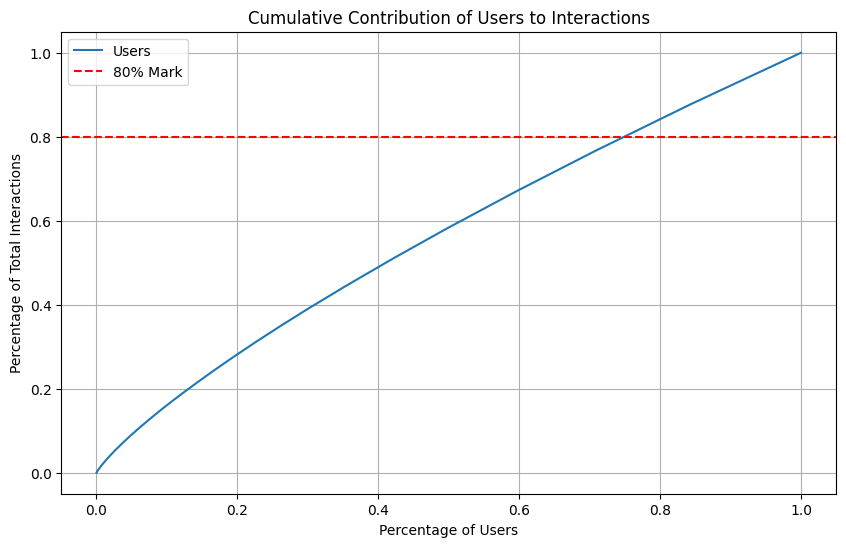

74.87% of users explain 80% of the interactions


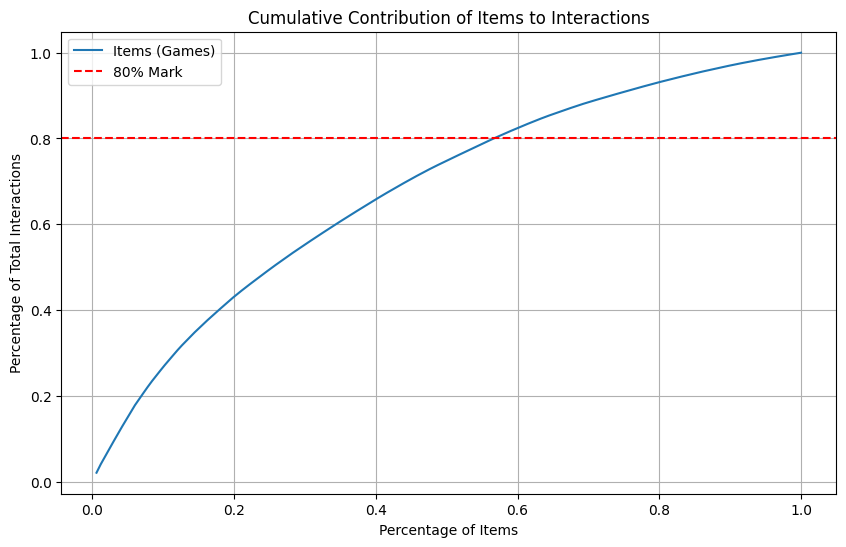

56.63% of items explain 80% of the interactions


In [ ]:
# find interactions for each user/item
user_interactions = merged_data_filtered.groupby('author.steamid')['app_id'].count().reset_index(name='user_interactions')
item_interactions = merged_data_filtered.groupby('app_id')['author.steamid'].count().reset_index(name='item_interactions')

# sort in descending order
user_interactions = user_interactions.sort_values(by='user_interactions', ascending=False).reset_index(drop=True)
item_interactions = item_interactions.sort_values(by='item_interactions', ascending=False).reset_index(drop=True)

# calculate cum sum
user_interactions['cumulative_user_interactions'] = user_interactions['user_interactions'].cumsum()
item_interactions['cumulative_item_interactions'] = item_interactions['item_interactions'].cumsum()

# calc total number of interactions =
total_user_interactions = user_interactions['user_interactions'].sum()
total_item_interactions = item_interactions['item_interactions'].sum()

# calculate pct
user_interactions['cumulative_user_pct'] = user_interactions['cumulative_user_interactions'] / total_user_interactions
item_interactions['cumulative_item_pct'] = item_interactions['cumulative_item_interactions'] / total_item_interactions

# calculate the proportion of users/items
user_interactions['user_pct'] = (user_interactions.index + 1) / len(user_interactions)
item_interactions['item_pct'] = (item_interactions.index + 1) / len(item_interactions)


# plot for user
plt.figure(figsize=(10, 6))
plt.plot(user_interactions['user_pct'], user_interactions['cumulative_user_pct'], label='Users')
plt.title('Cumulative Contribution of Users to Interactions')
plt.xlabel('Percentage of Users')
plt.ylabel('Percentage of Total Interactions')
plt.grid(True)
plt.axhline(0.80, color='red', linestyle='--', label='80% Mark')
plt.legend()
plt.show()
percent_users_explaining_80 = user_interactions[user_interactions['cumulative_user_pct'] >= 0.80].index[0] / len(user_interactions) * 100
print(f"{percent_users_explaining_80:.2f}% of users explain 80% of the interactions")

# plot for items
plt.figure(figsize=(10, 6))
plt.plot(item_interactions['item_pct'], item_interactions['cumulative_item_pct'], label='Items (Games)')
plt.title('Cumulative Contribution of Items to Interactions')
plt.xlabel('Percentage of Items')
plt.ylabel('Percentage of Total Interactions')
plt.grid(True)
plt.axhline(0.80, color='red', linestyle='--', label='80% Mark')
plt.legend()
plt.show()
percent_items_explaining_80 = item_interactions[item_interactions['cumulative_item_pct'] >= 0.80].index[0] / len(item_interactions) * 100
print(f"{percent_items_explaining_80:.2f}% of items explain 80% of the interactions")

## Creating Some Additional Features

### game_playtime_percentile
As game playtime varies across different types of games (e.g games with storyline have longer hours), playtime_at_review should be calcualated as a percentile compared to other users who played the same game


In [ ]:
merged_data_filtered['game_playtime_percentile'] = merged_data_filtered.groupby('app_id')['author.playtime_at_review'].rank(pct=True)


### game_description
combination of informative columns

In [ ]:
merged_data_filtered['game_description'] = merged_data_filtered['Genres'] + " " + merged_data_filtered['Categories'] + " " + merged_data_filtered['About the game']

In [ ]:
merged_data_filtered.describe()

,app_id,review_id,timestamp_updated,votes_helpful,weighted_vote_score,author.steamid,author.playtime_at_review,Required age,Price,DLC count,user_review_count,item_review_count,game_playtime_percentile
count,"126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000"
mean,"362,243.018","44,833,854.866","1,536,472,506.704",4.476,0.266,"76,561,198,094,133,840.000","4,039.514",5.876,22.977,12.147,27.346,"1,126.478",0.501
std,"225,743.799","19,997,758.994","56,102,076.260",67.813,0.257,"125,987,325.349","16,926.996",8.087,16.066,27.034,8.779,656.772,0.289
min,70.000,"1,512.000","1,290,229,222.000",0.000,0.000,"76,561,197,960,270,608.000",1.000,0.000,0.000,0.000,20.000,202.000,0.000
25%,"238,320.000","29,953,849.500","1,503,183,176.500",0.000,0.000,"76,561,198,019,445,456.000",341.000,0.000,9.990,1.000,22.000,603.000,0.251
50%,"322,330.000","43,691,197.000","1,545,658,688.000",0.000,0.385,"76,561,198,064,240,288.000",998.000,0.000,19.990,3.000,25.000,910.000,0.501
75%,"489,830.000","60,267,757.250","1,583,841,692.000",1.000,0.505,"76,561,198,126,975,024.000","3,006.000",17.000,29.990,13.000,30.000,"1,567.000",0.751
max,"1,289,310.000","85,216,383.000","1,611,423,009.000","13,595.000",0.979,"76,561,199,043,414,896.000","1,847,147.000",18.000,59.990,203.000,111.000,"2,587.000",1.000


# Using SteamAPI to Retrieve Users' Owned Games
this part was done early on, but since the API only allows us to get user information from non-private users, we could only yield user-owned-games from a small handful of users.

In [ ]:
df = merged_data_filtered

# keep unique users only
unique_users = df.drop_duplicates(subset=['author.steamid'])

# steam api initialisation
api_key = #### removed for submission
base_url = 'http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/'

# list to store data
owned_games_list = []

# loop thru each unique user
for index, row in unique_users.iterrows():
    steam_id = row['author.steamid']
    params = {
        'key': api_key,
        'steamid': steam_id,
        'format': 'json',
        'include_appinfo': 'true',  # include game name and logo
        'include_played_free_games': 'true'  # include free games as well
    }
    response = requests.get(base_url, params=params)

    # check if sucessful
    if response.status_code == 200:
        games = response.json().get('response', {}).get('games', [])
        game_details = [f"{game['name']} ({game['playtime_forever']} mins)" for game in games]  # collect game names and playtimes
        owned_games_list.append("; ".join(game_details))
    else:
        owned_games_list.append("Failed to fetch data")  # flag if fail
        print(f"Failed to fetch data for SteamID: {steam_id}")

# add list of owned games
unique_users['owned_games'] = owned_games_list

# Save the modified DataFrame to a CSV file
unique_users.to_csv('unique_users_game_history.csv', index=False)

### Merge Owned Games Back to Dataset

In [ ]:
game_history = pd.read_csv('unique_users_game_history.csv')

In [ ]:
merged_data_filtered = merged_data_filtered.merge(
    game_history[['author.steamid', 'owned_games']],
    how='left',
    on='author.steamid'
)

# EDA / Plots

In [ ]:
def plot_cat(col):
    sns.countplot(x=col, data=merged_data_filtered)
    plt.title(f'{col}')
    plt.show()


def plot_num(col):
    plt.figure(figsize=(8,5))

    sns.kdeplot(merged_data_filtered[col], fill=True)

    plt.title(f'{col} KDE Plot')
    plt.legend()
    plt.show()


In [ ]:
merged_data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126144 entries, 0 to 126143
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   app_id                     126144 non-null  int64  
 1   app_name                   126144 non-null  object 
 2   review_id                  126144 non-null  int64  
 3   review                     126144 non-null  object 
 4   timestamp_updated          126144 non-null  int64  
 5   recommended                126144 non-null  bool   
 6   votes_helpful              126144 non-null  int64  
 7   weighted_vote_score        126144 non-null  float64
 8   author.steamid             126144 non-null  int64  
 9   author.playtime_at_review  126144 non-null  float64
 10  Release date               126144 non-null  object 
 11  Required age               126144 non-null  int64  
 12  Price                      126144 non-null  float64
 13  DLC count                  12

In [ ]:
merged_data_filtered.describe()

,app_id,review_id,timestamp_updated,votes_helpful,weighted_vote_score,author.steamid,author.playtime_at_review,Required age,Price,DLC count,user_review_count,item_review_count,game_playtime_percentile
count,"126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000","126,144.000"
mean,"362,243.018","44,833,854.866","1,536,472,506.704",4.476,0.266,"76,561,198,094,133,840.000","4,039.514",5.876,22.977,12.147,27.346,"1,126.478",0.501
std,"225,743.799","19,997,758.994","56,102,076.260",67.813,0.257,"125,987,325.349","16,926.996",8.087,16.066,27.034,8.779,656.772,0.289
min,70.000,"1,512.000","1,290,229,222.000",0.000,0.000,"76,561,197,960,270,608.000",1.000,0.000,0.000,0.000,20.000,202.000,0.000
25%,"238,320.000","29,953,849.500","1,503,183,176.500",0.000,0.000,"76,561,198,019,445,456.000",341.000,0.000,9.990,1.000,22.000,603.000,0.251
50%,"322,330.000","43,691,197.000","1,545,658,688.000",0.000,0.385,"76,561,198,064,240,288.000",998.000,0.000,19.990,3.000,25.000,910.000,0.501
75%,"489,830.000","60,267,757.250","1,583,841,692.000",1.000,0.505,"76,561,198,126,975,024.000","3,006.000",17.000,29.990,13.000,30.000,"1,567.000",0.751
max,"1,289,310.000","85,216,383.000","1,611,423,009.000","13,595.000",0.979,"76,561,199,043,414,896.000","1,847,147.000",18.000,59.990,203.000,111.000,"2,587.000",1.000


## Plot Categorical Cols

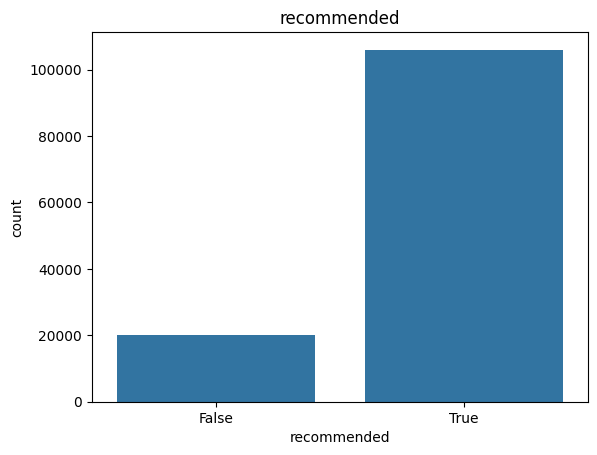

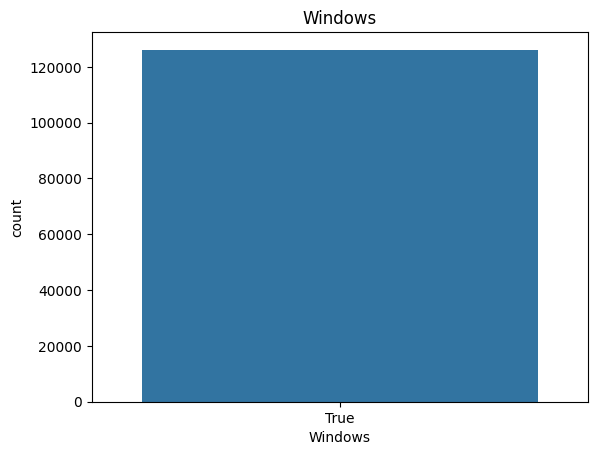

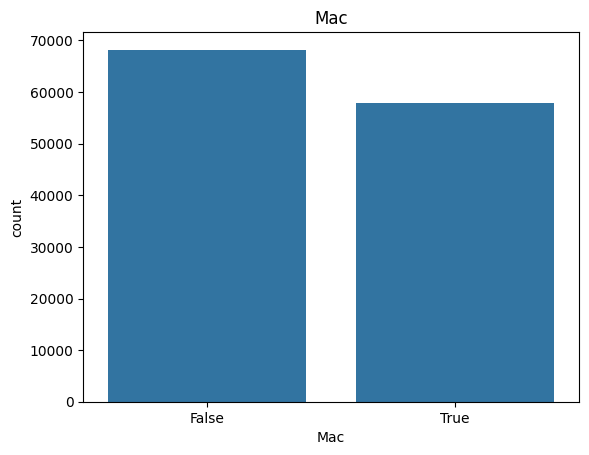

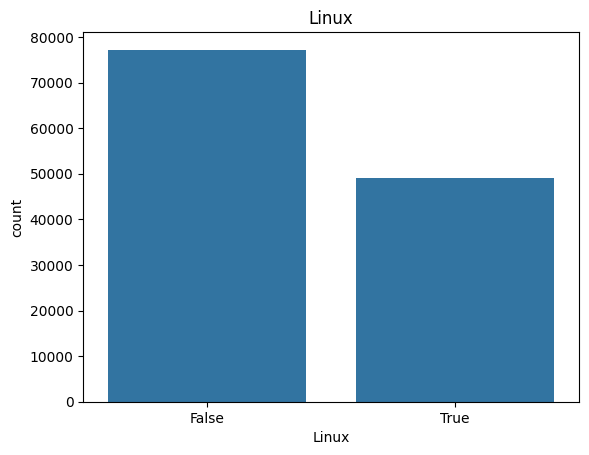

In [ ]:
cat_cols = merged_data_filtered.select_dtypes('bool').columns.tolist()

for col in cat_cols:
    plot_cat(col)

## Plot Numerical Cols

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


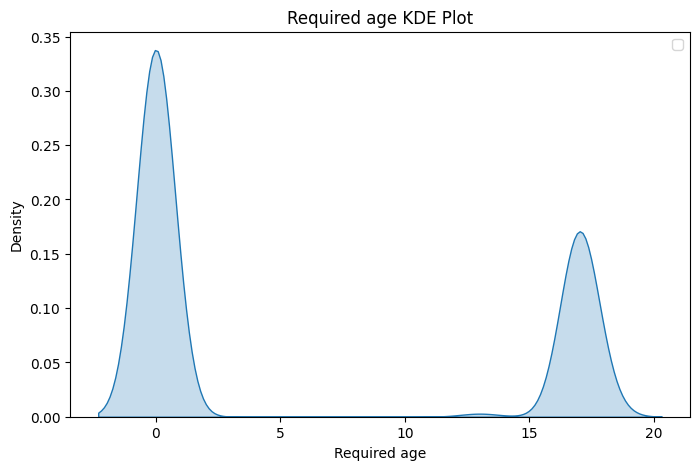

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


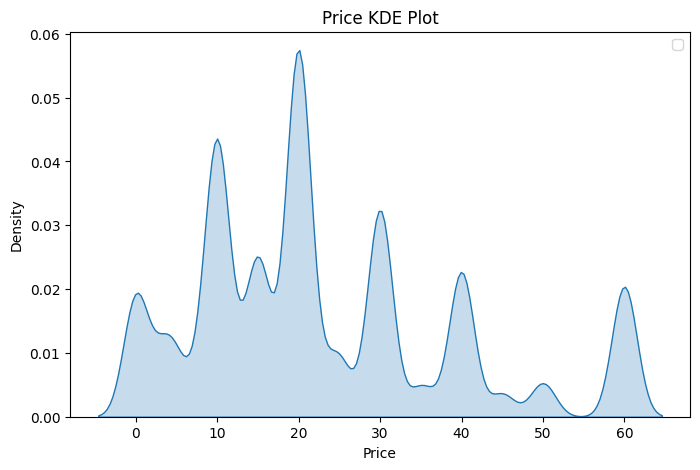

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


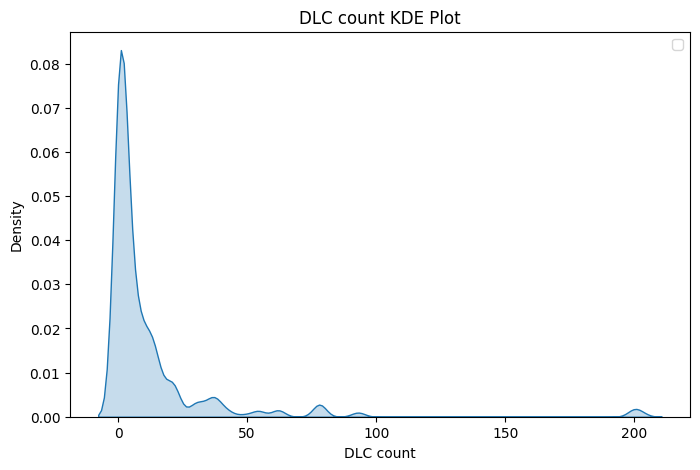

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


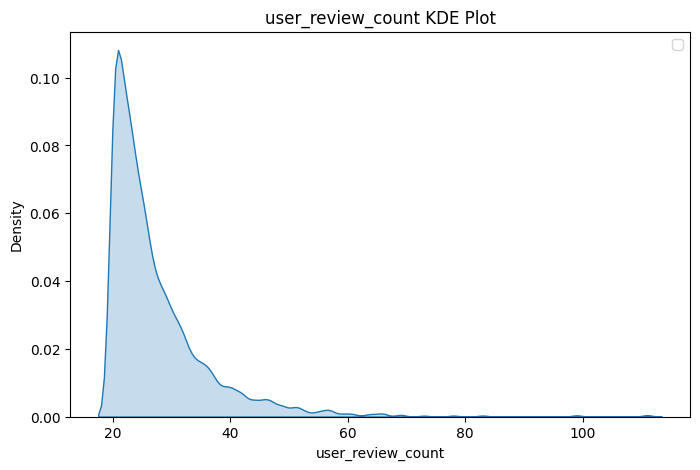

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


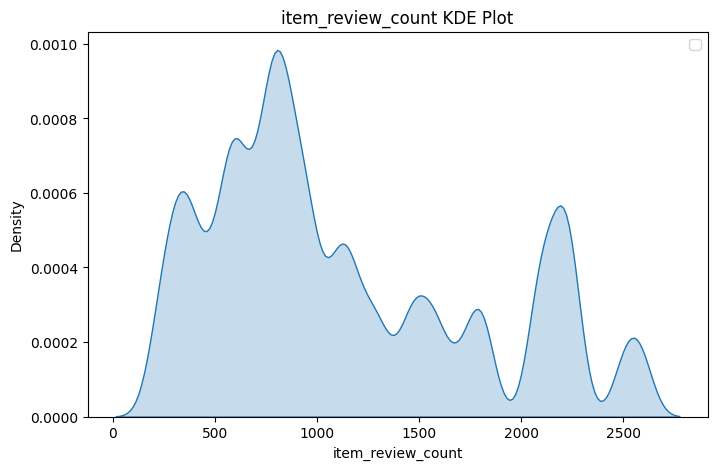

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


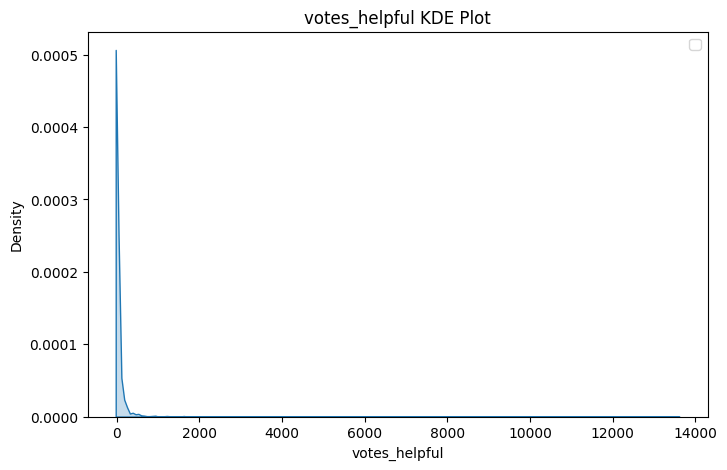

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


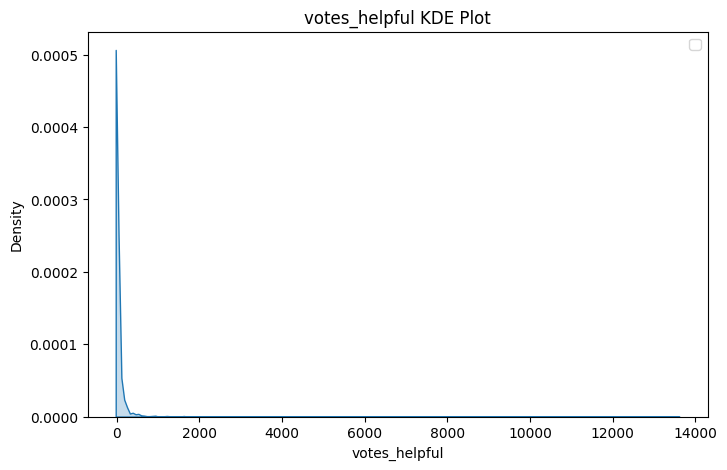

In [ ]:
num_cols = ['Required age','Price','DLC count','user_review_count','item_review_count','votes_helpful','votes_helpful']

for col in num_cols:
    plot_num(col)

## Explore the Comma Delimited Cols
- Genre, Publisher, Categories, Developers

In [ ]:
def get_value_counts(df, column_name, delimiter=';'):
    split_values = df[column_name].str.split(',').explode()
    return Counter(split_values)

columns_to_explore = ['Genres', 'Categories', 'Publishers', 'Developers']

eda_results = {}

for column in columns_to_explore:
    eda_results[column] = get_value_counts(merged_data_filtered, column)

for column, counts in eda_results.items():
    count_df = pd.DataFrame(counts.items(), columns=[column, 'Count']).sort_values(by='Count', ascending=False)
    null_count = merged_data_filtered[f"{column}"].isnull().sum()

    print(f"\n{column}")

    print(f"\nGames with null values for {column}: {null_count}")
    for game in merged_data_filtered[merged_data_filtered[f"{column}"].isnull()]['app_id']:
        print(game)


    print(f"\n{column} Value Counts:\n", count_df)


    print("\nDescriptive Stats:", count_df['Count'].describe())


Genres

Games with null values for Genres: 0

Genres Value Counts:
                    Genres  Count
1                  Action  81511
2               Adventure  49127
4                   Indie  48645
0                     RPG  39687
5              Simulation  25401
6                Strategy  24227
3                  Casual  11420
12  Massively Multiplayer   7949
11           Free To Play   4210
15                 Sports   1965
14                 Racing   1885
13           Early Access   1371
7    Animation & Modeling   1115
8   Design & Illustration   1115
9           Photo Editing   1115
10              Utilities   1115

Descriptive Stats: count       16.000
mean    18,866.125
std     24,168.521
min      1,115.000
25%      1,307.000
50%      6,079.500
75%     28,972.500
max     81,511.000
Name: Count, dtype: float64

Categories

Games with null values for Categories: 0

Categories Value Counts:
                     Categories   Count
0                Single-player  112844
8          

In [ ]:
merged_data_filtered.to_csv('bt4222_dataset_20.csv')